### Benchmarking SCINet GeoCDL Options

This notebook is designed to benchmark the throughput from various data sources to the USDA ARS HPC systems. Much of the code and inspiration for these metrics comes from a similiar effort via the Pangeo ([see this link](http://gallery.pangeo.io/repos/earthcube2020/ec20_abernathey_etal/cloud_storage.html) or this [preprint](https://www.authorea.com/doi/full/10.22541/au.160443768.88917719/v1))

This benchmark uses dask arrays and a dask distributed computing system to scale the number of workers fetching data from remote data repositories. To run a benchmark:
1. Copy the `template.ipynb` file.
2. Rename the file like:<br>
  * DataSource__FileType.ipynb (Note the double _ characters)
  * e.g. `template.ipynb` --> `aws__netcdf.ipynb`
  * e.g. `template.ipynb` --> `DukeFTP__Gdal_tif.ipynb`
3. Fill in the IO code in the "blank" section.
4. Run the entire notebook.
5. Confirm a file was written into the result folder.

**NOTE: You need to update the `container` variable in the 3rd cell below**

In [1]:
import warnings
warnings.filterwarnings('ignore')
from utils import DevNullStore,DiagnosticTimer,total_nthreads,total_ncores,total_workers,get_chunksize
import time, datetime, os, dask
import pandas as pd
import numpy as np
import dask.array as da
import dask_jobqueue as jq
from tqdm.notebook import tqdm
from dask.distributed import Client

In [2]:
## This environment set to optimized reading COG files - see https://github.com/pangeo-data/cog-best-practices

env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           AWS_NO_SIGN_REQUEST='YES',
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
           GDAL_SWATH_SIZE='200000000',
           VSI_CURL_CACHE_SIZE='200000000')

os.environ.update(env)

In [3]:
partition='brief-low'
num_processes = 3
num_threads_per_processes = 2
mem = 5.2*num_processes*num_threads_per_processes#*1.25,
n_cores_per_job = num_processes*num_threads_per_processes
container = 'docker://rowangaffney/data_science_im_rs:latest'
env = 'py_geo'
cluster = jq.SLURMCluster(queue=partition,
                          processes=num_processes,
                          memory=str(mem)+'GB',
                          cores=n_cores_per_job,
                          interface='ib0',
                          local_directory='$TMPDIR',
                          death_timeout=30,
                          python="singularity exec {} /opt/conda/envs/{}/bin/python".format(container,env),
                          walltime='01:30:00',
                          scheduler_options={'dashboard_address': ':8777'},
                          job_extra=["--output=/dev/null","--error=/dev/null"])
client=Client(cluster)
client

Client Scheduler: tcp://10.1.9.103:42046 Dashboard: http://10.1.9.103:8777/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Dataset Specific IO Code

Load data into a dask array named `data`. Ideally subset the data is it has ~100MB chunks and totals ~25 GBs. An example approach is:
```python
ds = xr.open_rasterio('http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/vrt/clay_mode_0_5.vrt',
                      chunks='auto')
data = ds.isel(x=slice(0,5400*5),y=slice(0,5400*5)).data
```

Define the following metadata:

**cloud_source** = Where is the data being housed <br>
**format** = Format of the data. For gdal drivers use gdal_drivername (aka gdal_tif). For other sources, use the file formatt suffix (aka zarr).<br>
**system** = The system (Ceres, Atlas, AWS, GCP, AZURE, etc...)

Example:
```python
cloud_source = 'aws_nasa_daac'
d_format = 'gdal_cog'
system = 'Ceres'
```

In [4]:
### ADD CODE BELOW ###
# Note this is really fast, so had to push the data size >25 GB to get good numbers for scaling to high cores

import xarray as xr
data = xr.open_zarr('/lustre/project/geospatial_tutorials/tutorial_1/data/cdl_data.zarr').CDL_Data.data
d_format = 'zarr'
cloud_source = 'local'
system = 'Ceres'
data

,Array,Chunk
Bytes,148.46 GB,62.50 MB
Shape,"(10, 96523, 153811)","(10, 2500, 2500)"
Count,2419 Tasks,2418 Chunks
Type,uint8,numpy.ndarray


### Run Diagnostics on Throughput

In [5]:
diag_timer = DiagnosticTimer()
devnull = DevNullStore()

chunksize = get_chunksize(data)
totalsize = data.nbytes*1e-9

diag_kwargs = dict(nbytes=data.nbytes,
                   chunksize=chunksize,
                   cloud_source=cloud_source,
                   system=system,
                   format=d_format)

n_worker_lst = [3,6,12,18,30,42,66,90]
runtime = datetime.datetime.now().strftime("%Y%m%d_%H%M")
for nworkers in tqdm(n_worker_lst):
    client.restart()
    cluster.scale(nworkers)
    time.sleep(10)
    client.wait_for_workers(nworkers)
    with diag_timer.time(nthreads=total_nthreads(client),
                         ncores=total_ncores(client),
                         nworkers=total_workers(client),
                         **diag_kwargs):

        future = da.store(data, devnull, lock=False, compute=False)
        dask.compute(future, retries=5)
df = diag_timer.dataframe()
cluster.scale(0)
df['throughput_MBps'] = df.nbytes/1e6/df.runtime

### Visualize and save the results

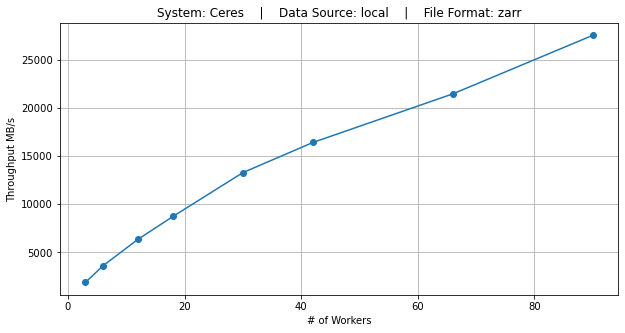

In [6]:
#Save results
df.to_csv('../results/Python__'+system+'__'+cloud_source+'__'+d_format+'__'+datetime.datetime.now().strftime("%Y%m%d_%H%M")+'.csv',index=False)

#Plot  nworkers v. Throughput
p = df.plot(x='nworkers',
            y='throughput_MBps',
            title='System: '+system+'    |    Data Source: '+cloud_source+'    |    File Format: '+d_format,
            grid=True,
            style='.-',
            figsize=(10,5),
            ylabel='Throughput MB/s',
            xlabel='# of Workers',
            ms=12,
            legend=False)